In [3]:
#IGNORE
!which python # should return /usr/local/bin/python

/usr/local/bin/python


In [4]:
#IGNORE
!python --version

Python 3.7.12


In [2]:
#IGNORE

#mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#IGNORE

!wget 'https://cildata.crbs.ucsd.edu/media/images/37249/37249.tif'

--2022-01-21 18:18:36--  https://cildata.crbs.ucsd.edu/media/images/37249/37249.tif
Resolving cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)... 67.58.57.218
Connecting to cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)|67.58.57.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66400000 (63M) [image/tiff]
Saving to: ‘37249.tif’

37249.tif           100%[===================>]  63.32M  34.3MB/s    in 1.8s    

2022-01-21 18:18:38 (34.3 MB/s) - ‘37249.tif’ saved [66400000/66400000]



In [9]:
#IGNORE

import numpy as np
import skimage as sk
import skimage.io
from skimage.util import img_as_float
from skimage.filters import unsharp_mask
import os
import matplotlib.pyplot as plt
import random 

In [ ]:
import numpy as np
import wget
import skimage as sk
import skimage.io
from skimage.util import img_as_float
from skimage.filters import unsharp_mask
import os
import matplotlib.pyplot as plt

###Note: Please see the accompanying paper "Quantifying glial-glial tiling using automated image analysis" for a full description of the pipeline and its validation.



# Download Test Data
You can find a set of 60 sample images (20 non-RNAi control, 20 driver 1 knockdown, and 20 driver 2 knockdown) hosted by the [Cell Image Library](http://www.cellimagelibrary.org/).

Though we provided 60 images to conduct a thorough test of the pipeline, for those interested in a quick test, we recommend only running 3-5 images to reduce running time. 

In [ ]:
#Since we don't actually have a link for our data in the repository yet,
#This is just downloading random images
#This works fine but please don't run the code below with those random images
#in the TestImages folder (won't work)

url_list = ['https://cildata.crbs.ucsd.edu/media/images/37249/37249.tif',
       'https://cildata.crbs.ucsd.edu/media/images/37250/37250.tif']

#make directory for test images
if not os.path.exists('TestImages'):
    os.makedirs('TestImages')

#download images into directory
for img in url_list:
    img_name = img.split('/')[-1]
    path = os.path.join ('TestImages', img_name)
    wget.download(img, out = path)

100% [....................................................] 59600000 / 59600000

# Step 1: Denoising
Denoising reduces the noise in images allowing for more accurate binary images to be produced in the next step. We found the unsharp mask algorithm to be the most useful for denoising our data. The code below uses scikit-image's implementation of the algorithm to denoise a random test image for demonstration purposes. 

6L WT 5-9 Ctx488 AstroCy3 ElavCy5 20x 5.63X_20.tif


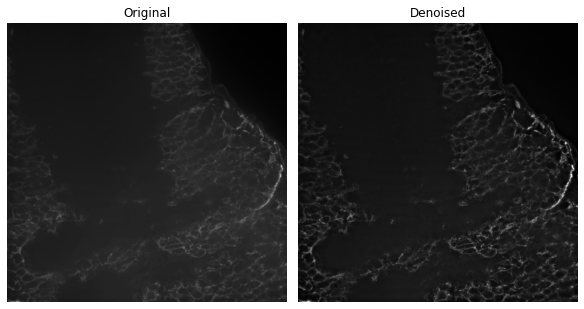

In [19]:
####DENOISE RANDOM TEST IMAGE#####

#make list of test image file names
dirPath = "/content/drive/MyDrive/Coutinho-Budd Lab/TilingMethods/Github/TestImages"

testImgs = []
for root, dir, file in os.walk(dirPath):
    for f in file:
        if '.tif' in f:
            testImgs.append(f)

#choose random image file
imgName = random.choice(testImgs)
ipath=os.path.join(dirPath, imgName)
#select random channel
channel = [0, 1, 2]
c = random.choice(channel)
#load image with skimage
fullimg=skimage.io.imread(ipath, plugin="tifffile")
#select single channel 
original=fullimg[:, :, c]

#denoise image using unsharp mask 
# original = img_as_float(original)
#set radius and amount parameters
r = 20; amt = 2
denoised = unsharp_mask (original, radius=r, amount=amt)

#print image file name
print(imgName)

#create figure showing original and denoised image
#create figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                               figsize=(8, 16), constrained_layout=True)
#show original image
ax1.imshow(original, cmap=plt.cm.gray)
ax1.set_title('Original')
#show denoised image
ax2.imshow(denoised, cmap=plt.cm.gray)
ax2.set_title('Denoised')
#remove axes from figure
ax1.axis('off')
ax2.axis('off')
plt.show()


##Troubleshooting: Denoising 

The function below, test_unsharp_mask, is to be used for optimizing parameters for the unsharp mask method. It takes 3 values for each the radius and amount parameters to produce 9 possible parameter sets, applies the unsharp mask with each parameter set to each test image, and produces a figure showing the 9 denoised images for each test image. We found it necessary to optimize a single channel at a time, which needs to be indicated in the test_unsharp_mask function by the channel parameter. The results are saved in a results directory named by the user.

Users may find the unsharp mask unsuitable for their images. Scikit-image provides many denoising algorithms in the restoration and filters modules. 

https://scikit-image.org/docs/stable/api/skimage.restoration.html

https://scikit-image.org/docs/stable/api/skimage.filters.html

The code below can be adapted to run a different denoising algorithm, or multiple different denoising algorithms on a set of test images. 

In [62]:
def test_unsharp_mask(dataDir, resultsDir, channel, radii, amts):
    '''For optimizing parameters for the radius and amount parameters. 
    Tests 3  values for the radius and amount paramaters of the unsharp mask algorithm. 
    For each test image, produces a figure showing results using all parameter sets. 
    Figures are stored in resultsDir directory.'''
    #create results directory
    if not os.path.exists(resultsDir):
        os.makedirs(resultsDir)
    #for each image
    for root, directory, file in os.walk(dataDir):
        for f in file:
            if '.tif' in f:
                ipath=os.path.join(root, f)
                #load image with skimage
                fullimg=skimage.io.imread(ipath, plugin="tifffile")
                #select single channel
                original=fullimg[:, :, channel]
                #create list of all parameter sets to test
                parameter_sets = []
                for r in radii:
                    for amt in amts:
                        par_s = (r, amt)
                        parameter_sets.append(par_s)
                #create figure
                fig, axes = plt.subplots(nrows=4, ncols=3,
                sharex=True, sharey=True, figsize=(12, 20), tight_layout=True)
                ax = axes.ravel()
                #add original image on figure
                ax[0].imshow(original, cmap=plt.cm.gray)
                ax[0].set_title('Original image: ' + f)
                ax[0].axis('off')
                #remove 2nd and 3rd axes
                ax[1].remove()
                ax[2].remove()
                #iterate thru parameter sets
                for par_s, a in zip(parameter_sets, ax[3:]):
                    #run unsharp mask
                    r, amt = par_s
                    res = unsharp_mask(original, radius=r, amount=amt)
                    a.imshow(res, cmap=plt.cm.gray)
                    a.set_title ('Enhanced, radius=' + str(r) + ', amount=' + str(amt))
                    a.axis('off')
                #save results
                imgID = f.replace('.tif', '')
                figpath=os.path.join(resultsDir, imgID + '_UnsharpMask' + '.png')
                plt.savefig(figpath, format='png', pad_inches=0.3, bbox_inches='tight')
                plt.close()
        return ()

In [63]:
#test data directory
dataDir = '/content/drive/MyDrive/Coutinho-Budd Lab/TilingMethods/Github/TestImages'
#results directory
#this would just be a relative path in Jupyter notebook 
root = '/content/drive/MyDrive/Coutinho-Budd Lab/TilingMethods/Github'
dir = 'UnsharpMaskResults'
resultsDir = os.path.join(root, dir)
#channel to be denoised
channel = 0
#list of 3 values for radius parameter
radii = [1, 5, 20]
#list of 3 values for amount parameter
amts = [1, 2, 3]

#run unsharp mask on test images
par_sets = test_unsharp_mask(dataDir, resultsDir, channel, radii, amts)

# Step 2: Thresholding

Thresholding produces the binary images necessary for image quantification. As with denoising, we optimized thresholding separately for each channel. We were unable to find a single thresholding algorithm that produced optimal binary images for all test images. We implemented a decision tree to choose the most appropriate method for each image. 

The code below binarizes a denoised neuronal nuclei image by choosing between the Otsu, triangle and Li thresholding methods. We took advantage of the difference in texture between the neuronal nuclei (circles) and noise (small specks), and the fact that there are neurons in every slice of the stack, in order to code rules to determine when a thresholding method is over or underestimating the amount of true signal. 

In [2]:
#THRESHOLDING CODE

##Troubleshooting: Thresholding 

### Algorithm selection

For generating our thresholding decision tree, we first used the [try_all_threshold function](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html) to binarize a set of denoised test images and chose 2-3 algorithms (for each channel) that would result in at least one satisfactory binarization of each test image. Scikit-image provides other thresholding algorithms users may wish to use instead, including local thresholding algorithms, in the [filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) modules. 

The function below runs the try_all_threshold function to binarize a set of denoised test images and stores the results in a directory denoted by the user. 





In [19]:
#code

### Decision Tree

The code below was used to optimize the decision tree for thresholding the neuronal nuclei channel. It runs the Otsu, triangle and Li methods on each of the test images and produces a figure showing the results of each algorithm, as well as which it would select to threshold the given image. The function can be modified to choose between different thresholding algorithms or use different rules for choosing the optimal threshold. 

In [ ]:
#code

# Step 3: Quantification 

##Globularity Quantification: AMI
The perimeter is used as a proxy for automatically quantifying globularity. A highly significant negative relationship was established between cortex glia perimeter and globularity by comparing the length of the perimeter, normalized by cortex area, to globularity scores manually assigned by researchers. You can fnd the code for assessing this relationship in the AMI_Validation.py in this repo and a full explanation of the validation process in our accompanying paper. 

##Aberrant Infiltration Quantification: AIS
Aberrant infiltration is measured as the overlap between the cortex region and the astrocyte channel. Automated infiltration quantification was validated by comparing manual and automated scores. You can find the code for this validation in AIS_Validation.py in this repo and a full explanation of the validation process in our accompanying paper. 

The code below performs globularity and aberrant infiltration simultaneously on 3-channel 2D images, and was used to produce preliminary AMI and AIS scores for validating the pipeline. For the final analysis, the full 3-channel z-stacks were quantified. The code for that quantification can be found in Z_Stack_Quantification.py in this repo. 


In [ ]:
#code

## Troubleshooting: AIS

### Cortex Segmentation Optimization

We determined values for the 4 cortex_segmentation function parameters by comparing automated to manual segmentation. We maximized the overlap between the segmented regions while minimizing the area included in the automatically-segmented region that was not present in the manually-segmented region. You can find the code for this optimization in Cortex_Segmentation_Optimization.py and a full explanation of the optimization process in our accompanying paper. The values of these parameters can be adjusted as necessary to yield scores that more accurately reflect manual scores. 

### Removing Cell Bodies

Astrocyte cell bodies lie on the edge of the cortex region and may be erroneously counted as aberrant infiltration. After performing preliminary infiltration quantification, cell bodies are identified using features such as solidity, area, and eccentricity and excluded from the final score. For the selection of parameter values we labeled all objects in the initial infiltration quantification, manually assigned them a label of “true” or “false” infiltration and chose parameter values that maximized the number of “true” and minimized the number of “false” particles included in the final infiltration count. You can find code for labeling infiltration objects in Cell_Body_Identification.py. 

Scikit-image offers [functions](https://colab.research.google.com/drive/1RnDEMb2QYd2AsKFXV1Qs7q5RwQTUx-TE#scrollTo=EmoMoFlkGrbd&line=11&uniqifier=1) for measuring many features that can be used to identify objects that need to be excluded from an image quantification. 

In [ ]:
#code

#Step 4: Analysis 

After quantifycation of all z-stacks, we performed two types of analysis: one considering global scores and the other considering local scores. 

##Global Scores
Global scores are the average of all the slices in a z-stack, representing the VNC of a single animal. We compared global AMI and AIS of the three groups (two RNAi knockdown conditions and one no-RNAi control) using a Kruskal-Wallis test followed by a Dunn pairwise comparisons. We also assessed the relationship between globularity and infiltration using Spearman’s rank correlation coefficient. The full analysis code for global scores can be found in Global_Score_Analysis.py. 

##Local scores
Local scores are the average of a subset of the slices in a z-stack, represent a subregion of the VNC. A sliding window was used to average the scores for 10% of the total slices in a stack at a time, showing how AMI and AIS vary through the dorsal-ventral axis of the VNC. The relationship between corresponding local globularity and infiltration scores was calculated using Spearman’s rank correlation coefficient, showing how the relationship between the two features varies along the dorsal ventral axis. The full analysis code for local scores can be found in Local_Score_Analysis.py. 



In [ ]:
#test data directory
dataDir = '/content/drive/MyDrive/Coutinho-Budd Lab/TilingMethods/Github/TestImages'
#results directory
#this would just be a relative path in Jupyter notebook 
root = '/content/drive/MyDrive/Coutinho-Budd Lab/TilingMethods/Github'
dir = 'UnsharpMaskResults'
resultsDir = os.path.join(root, dir)
#channel to be denoised
channel = 0
#list of 3 values for radius parameter
radii = [1, 5, 20]
#list of 3 values for amount parameter
amts = [1, 2, 3]

#create results directory
if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)
#for each image
for root, directory, file in os.walk(dataDir):
    for f in file:
        if '.tif' in f:
            ipath=os.path.join(root, f)
            #load image with skimage
            fullimg=skimage.io.imread(ipath, plugin="tifffile")
            #select single channel
            original=fullimg[:, :, channel]
            original = img_as_float(original)
            image = np.copy(original)
            #create figure
            fig, axes = plt.subplots(nrows=4, ncols=3,
            sharex=True, sharey=True, figsize=(10, 13), constrained_layout=True)
            ax = axes.ravel()
            ## put original image on figure
            # ax[0].imshow(image, cmap=plt.cm.gray)
            # ax[0].set_title('Original image: ' + f)
            # ax[0].axis('off')
            # #don't need 2 and 3 axes
            # ax[1].remove()
            # ax[2].remove()
            #create list of all parameter sets
            parameter_sets = []
            for r in radii:
                for amt in amts:
                    par_s = (r, amt)
                    parameter_sets.append(par_s)
            for par_s in parameter_sets:



#             #iterate thru parameter sets
#             for par_s, a in zip(parameter_sets, ax[1:]):
#                 #run unsharp mask
#                 r = par_s[0]
#                 amt = par_s[1] 
#                 res = unsharp_mask(image, radius=r, amount=amt)
#                 a.imshow(res, cmap=plt.cm.gray)
#                 title = 'Enhanced, radius=' + str(r) + ', amount=' + str(amt)
# #                     a.set_title('hello')
#                 a.axis('off')
            #save results
            # imgID = f.replace('.tif', '')
            # figpath=os.path.join(resultsDir, imgID + '_UnsharpMask' + '.png')
            # plt.savefig(figpath, format='png', pad_inches=0.3, bbox_inches='tight')
            # plt.show()

In [12]:
def test_unsharp_mask(dataDir, resultsDir, channel, radii, amts):
    '''For optimizing parameters for the radius and amount parameters. 
    Tests 3  values for the radius and amount paramaters of the unsharp mask algorithm. 
    For each test image, produces a figure showing results using all parameter sets. 
    Figures are stored in resultsDir directory.'''
    #create results directory
    if not os.path.exists(resultsDir):
        os.makedirs(resultsDir)
    #for each image
    for root, directory, file in os.walk(dataDir):
        for f in file:
            if '.tif' in f:
                ipath=os.path.join(root, f)
                #load image with skimage
                fullimg=skimage.io.imread(ipath, plugin="tifffile")
                #select single channel
                original=fullimg[:, :, channel]
                original = img_as_float(original)
                image = np.copy(original)
                #create figure
                fig, axes = plt.subplots(nrows=4, ncols=3,
                sharex=True, sharey=True, figsize=(10, 13), constrained_layout=True)
                ax = axes.ravel()
                #put original image on figure
                ax[0].imshow(image, cmap=plt.cm.gray)
                ax[0].set_title('Original image: ' + f)
                ax[0].axis('off')
                #don't need 2 and 3 axes
                ax[1].remove()
                ax[2].remove()
                #create list of all parameter sets
                parameter_sets = []
                for r in radii:
                    for amt in amts:
                        par_s = (r, amt)
                        parameter_sets.append(par_s)
                #iterate thru parameter sets
                for par_s, a in zip(parameter_sets, ax[1:]):
                    #run unsharp mask
                    r = par_s[0]
                    amt = par_s[1] 
                    res = unsharp_mask(image, radius=r, amount=amt)
                    a.imshow(res, cmap=plt.cm.gray)
                    title = 'Enhanced, radius=' + str(r) + ', amount=' + str(amt)
#                     a.set_title('hello')
                    a.axis('off')
                #save results
                imgID = f.replace('.tif', '')
                figpath=os.path.join(resultsDir, imgID + '_UnsharpMask' + '.png')
                plt.savefig(figpath, format='png', pad_inches=0.3, bbox_inches='tight')
                # plt.show()
        return (parameter_sets)

In [ ]:
print(par_sets)

()


In [ ]:
r = 1
amt = 15

test = 'Enhanced, radius=' + str(r) + ', amount=' + str(amt)
print(test)

Enhanced, radius=1, amount=15


In [ ]:
for root, directory, file in os.walk(dirName):
    for f in file:
        ipath=os.path.join(root, f)
        fullimg=skimage.io.imread(ipath, plugin="tifffile")
        original=fullimg[:, :, 0]
        original = img_as_float(original)
        
        image = np.copy(original)

        result_1 = unsharp_mask(image, radius=1, amount=1)
        result_2 = unsharp_mask(image, radius=1, amount=2)
        result_3 = unsharp_mask(image, radius=1, amount=3)
        result_4 = unsharp_mask(image, radius=5, amount=1)
        result_5 = unsharp_mask(image, radius=5, amount=2)
        result_6 = unsharp_mask(image, radius=5, amount=3)
        result_7 = unsharp_mask(image, radius=20, amount=1)
        result_8 = unsharp_mask(image, radius=20, amount=2)
        result_9 = unsharp_mask(image, radius=20, amount=3)

        fig, axes = plt.subplots(nrows=4, ncols=3,
        sharex=True, sharey=True, figsize=(10, 13), constrained_layout=True)
        
        ax = axes.ravel()
        
        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].set_title('Original image: ' + f)
        
        ax[1].remove()
        ax[2].remove()

        ax[3].imshow(result_1, cmap=plt.cm.gray)
        ax[3].set_title('Enhanced, radius=1, amount=1.0')
        ax[3].axis('off')

        ax[4].imshow(result_2, cmap=plt.cm.gray)
        ax[4].set_title('Enhanced, radius=1, amount=2.0')
        ax[5].imshow(result_3, cmap=plt.cm.gray)
        ax[5].set_title('Enhanced, radius=1, amount=3.0')
        
        ax[6].imshow(result_4, cmap=plt.cm.gray)
        ax[6].set_title('Enhanced, radius=5, amount=1.0')
        ax[7].imshow(result_5, cmap=plt.cm.gray)
        ax[7].set_title('Enhanced, radius=5, amount=2.0')
        ax[8].imshow(result_6, cmap=plt.cm.gray)
        ax[8].set_title('Enhanced, radius=5, amount=3.0')
        
        ax[9].imshow(result_7, cmap=plt.cm.gray)
        ax[9].set_title('Enhanced, radius=20, amount=1.0')
        ax[10].imshow(result_8, cmap=plt.cm.gray)
        ax[10].set_title('Enhanced, radius=20, amount=2.0')
        ax[11].imshow(result_9, cmap=plt.cm.gray)
        ax[11].set_title('Enhanced, radius=20, amount=3.0')
        
        for a in ax:
            a.axis('off')
            
        plt.show()

40657.tif


In [17]:
#code